<a href="https://colab.research.google.com/github/chasubeen/python_selfstudy/blob/master/deep_pytorch/2.%20CNN%EA%B3%BC%20LSTM%20%EA%B2%B0%ED%95%A9%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. CNN과 LSTM으로 신경망 만들기**
- CNN:
  - 주로 입력 이미지를 가져와 고차원 특징이나 임베딩을 출력하는 **인코더**로 사용됨
  - 사전 훈련된(pre-trained) 모델을 가져와 사용
- LSTM:
  - 마지막 은닉 계층으로 활용
  - 텍스트를 생성하는 디코더 역할
  - t=0일 때 CNN 임베딩을 입력으로 가져오면 LSTM의 각 셀은 시간 단계마다 토큰을 예측해, 다음 LSTM 셀에 입력으로 제공

## **1-1. 텍스트 인코딩 데모**
- 텍스트 데이터를 다루기 위해서는 토큰(단어 및 문장 부호)을 숫자로 나타내는 작업이 필요
- 텍스트의 각 토큰을 그에 대응하는 고유한 숫자로 표현
  - 각 단어와 토큰을 숫자에 매핑 => 사전

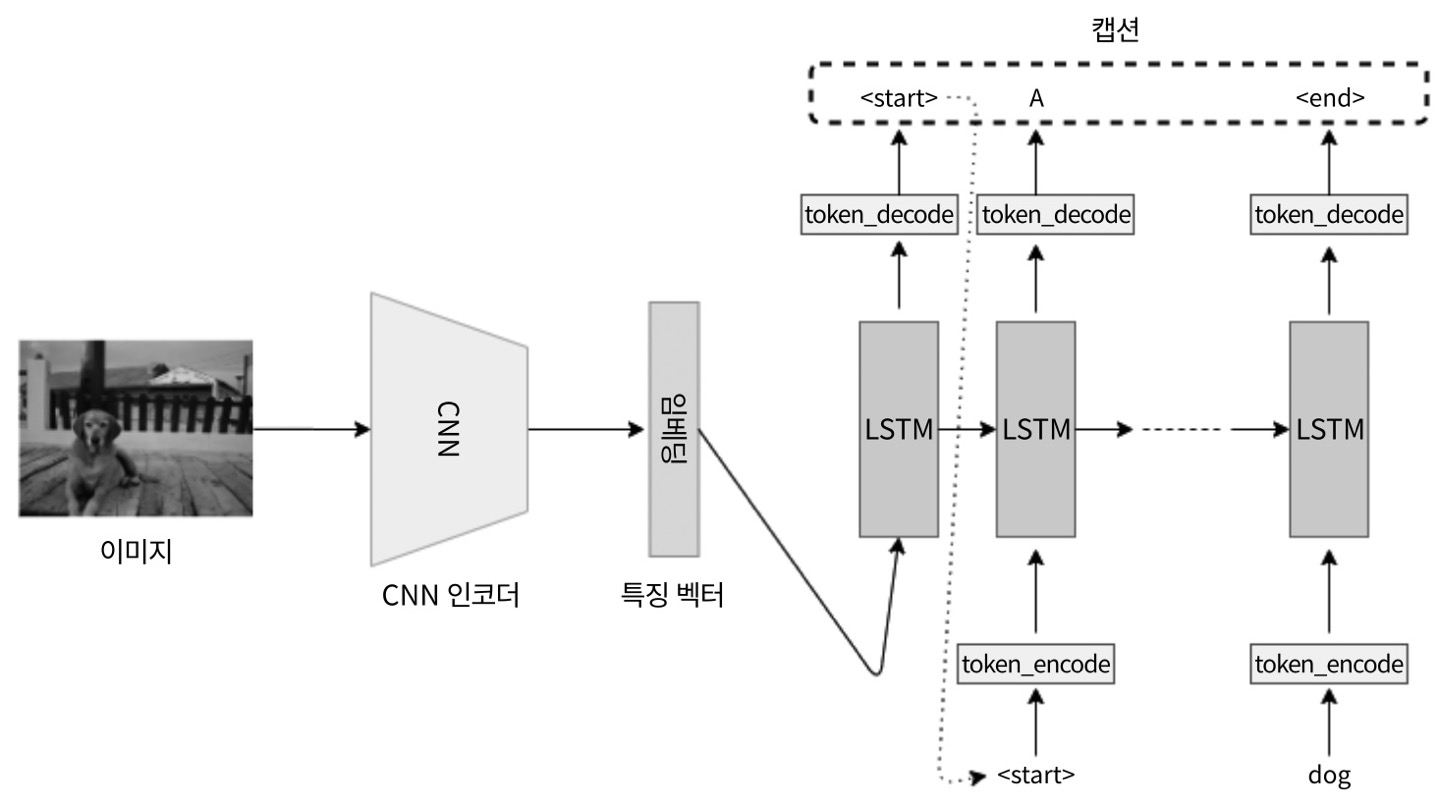

# **2. 파이토치로 이미지 캡션 생성하기**
- 활용 데이터셋: COCO(Common Objects in Context)  
[데이터셋 링크](https://cocodataset.org/#overview)

## **2-1. 이미지 캡션 데이터셋 다운로드**

In [ ]:
## linux
!apt-get install wget

## create a data directory
!mkdir data_dir

## download images and annotations to the data directory
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/

## extract zipped images and annotations and remove the zip files
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip

## **2-2. 캡션(텍스트) 데이터 전처리**

### **Library Import**

In [ ]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence # 다양한 길이(단어 개수)의 문장에 패딩을 적용해 고정된 길이의 문장으로 변환 시 사용

In [ ]:
nltk.download('punkt') # 토크나이저 다운로드

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**사전 정의**
- 텍스트 토큰 to 숫자 토큰

In [ ]:
class Vocab(object):
  """Simple vocabulary wrapper."""
  def __init__(self):
    self.w2i = {} # 텍스트 -> 숫자
    self.i2w = {} # 숫자 -> 텍스트
    self.index = 0

  def __call__(self, token):
    if not token in self.w2i:
        return self.w2i['<unk>']
    return self.w2i[token]

  def __len__(self):
    return len(self.w2i)

  def add_token(self, token):
    if not token in self.w2i:
      self.w2i[token] = self.index
      self.i2w[self.index] = token
      self.index += 1

In [ ]:
def build_vocabulary(json, threshold):
    """사전 래퍼(wrapper) 구축"""
    ## JSON 텍스트 annotation을 로딩
    coco = COCO(json)
    ## annotation, caption 내의 개별 단어를 토큰화하거나 숫자로 전환 후 카운터에 저장
    counter = Counter()
    ids = coco.anns.keys()

    for i, id in enumerate(ids):
      caption = str(coco.anns[id]['caption'])
      tokens = nltk.tokenize.word_tokenize(caption.lower())
      counter.update(tokens)

      if (i+1) % 1000 == 0:
        print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    ## 특정 횟수 이상 발생한 토큰만 저장(기준점 이하의 토큰은 제거)
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    ## Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>') # 패딩
    vocab.add_token('<start>') # 시작
    vocab.add_token('<end>') # 끝
    vocab.add_token('<unk>') # 모르는 단어

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
      vocab.add_token(token)
    return vocab

In [ ]:
### 사전 구축

vocab = build_vocabulary(json = 'data_dir/annotations/captions_train2014.json', threshold = 4)
vocab_path = './data_dir/vocabulary.pkl'

with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

## **2-3. 이미지 데이터 전처리**
- CNN 모델 아키텍처에 맞도록 전체 이미지를 256 * 256 픽셀로 모양 변경

In [ ]:
### 이미지 크기 고정
# 일정한 크기로 처리될 수 있도록 이미지 크기 재조정

def reshape_image(image, shape):
  """Resize an image to the given shape."""
  return image.resize(shape, Image.ANTIALIAS)

def reshape_images(image_path, output_path, shape):
  """Reshape the images in 'image_path' and save into 'output_path'."""
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  images = os.listdir(image_path)
  num_im = len(images)
  for i, im in enumerate(images):
    with open(os.path.join(image_path, im), 'r+b') as f:
      with Image.open(f) as image:
        image = reshape_image(image, shape)
        image.save(os.path.join(output_path, im), image.format)
    if (i+1) % 100 == 0:
      print ("[{}/{}] Resized the images and saved into '{}'.".format(i+1, num_im, output_path))

In [ ]:
image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]

reshape_images(image_path, output_path, image_shape)

## **2-4. 이미지 캡션 데이터로더 정의**
- 전처리된 데이터를 파이토치 데이터셋 객체로 캐스팅하는 과정
- 해당 데이터셋 객체는 이루 훈련 루프에서 데이터 배치를 가져오기 위해 사용할 파이토치 데이터로더 객체를 정의하는 데 활용될 수 있음

In [ ]:
class CustomCocoDataset(data.Dataset):
  """torch.utils.data.DataLoader와 호환되는 COCO 데이터셋"""
  ### 맞춤형 파이토치 Dataset 객체를 정의하기 위한 인스턴스화를 위한 메서드
  def __init__(self, data_path, coco_json_path, vocabulary, transform = None):
    """이미지, 텍스트, 사전 래퍼를 저장한 경로 설정
    Args:
      root: image directory.
      json: coco annotation file path.
      vocab: vocabulary wrapper.
      transform: image transformer.
    """
    self.root = data_path
    self.coco_data = COCO(coco_json_path)
    self.indices = list(self.coco_data.anns.keys())
    self.vocabulary = vocabulary
    self.transform = transform

  ### 아이템을 가져오기 위한 메서드
  def __getitem__(self, idx):
    """데이터 샘플 (X: image, y: caption) 1개 반환"""
    coco_data = self.coco_data
    vocabulary = self.vocabulary
    annotation_id = self.indices[idx]
    caption = coco_data.anns[annotation_id]['caption']
    image_id = coco_data.anns[annotation_id]['image_id']
    image_path = coco_data.loadImgs(image_id)[0]['file_name']
    image = Image.open(os.path.join(self.root, image_path)).convert('RGB')

    if self.transform is not None:
      image = self.transform(image)

    # Convert caption (string) to word ids.
    word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(vocabulary('<start>'))
    caption.extend([vocabulary(token) for token in word_tokens])
    caption.append(vocabulary('<end>'))
    ground_truth = torch.Tensor(caption)
    return image, ground_truth

  # 데이터셋 크기 반환
  def __len__(self):
    return len(self.indices)

In [ ]:
### X, y 형태로 데이터의 미니 배치를 반환하는 collate_function

def collate_function(data_batch):
    """데이터 미니 배치 생성(image, caption)
    문장 길이(k)가 고정된 길이 n보다 작을 때 패딩 토큰을 추가
    표준 collate_fn(수집 함수)는 패딩을 지원하지 않기에 사용자 정의 함수 구성
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (:); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """

    # 캡션 길이 기준 내림차순 정렬
    data_batch.sort(key = lambda d: len(d[1]), reverse = True)
    imgs, caps = zip(*data_batch)

    ## Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256) -> 채널, height, width
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
      end = cap_lens[i]
      tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

In [ ]:
### 맞춤형 데이터로더 반환

def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """COCO 데이터셋을 위한 맞춤형 데이터로더를 반환하는 함수"""
    ## COCO 데이터셋
    coco_dataser = CustomCocoDataset(data_path = data_path,
                       coco_json_path = coco_json_path,
                       vocabulary = vocabulary,
                       transform = transform)

    ## Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset = coco_dataser,
                                              batch_size = batch_size,
                                              shuffle = shuffle,
                                              num_workers = num_workers,
                                              collate_fn = collate_function)
    return custom_data_loader

## **2-5. CNN-LSTM 모델 정의하기**

### **CNN 모델 정의**
- 사전 훈련된 모델로 ResNet 152 아키텍처 사용
  - 152개의 계층으로 구성됨
  - ImageNet 데이터셋을 통해 사전 훈련됨
- ImageNet 데이터셋
  - 1000개 이상의 클래스 레이블이 지정된 140만개 이상의 RGB 이미지가 포함되어 있음
  - 식물, 동물, 음식, 스포츠 등의 범주

**❓ 완전 연결 계층을 대체하는 이유?**
- 마지막 계층을 대체함으로써 마지막 가중치 행렬을 임의로 초기화한 새로운 가중치 행렬로 대체

In [ ]:
class CNNModel(nn.Module):
  def __init__(self, embedding_size):
    """사전 훈련된 ResNet-152 로딩 & 마지막 완전 연결 계층 대체"""
    super(CNNModel, self).__init__()
    resnet = models.resnet152(pretrained = True)
    module_list = list(resnet.children())[:-1]      # 사전 학습된 마지막 FC Layer 제거
    self.resnet_module = nn.Sequential(*module_list)
    self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
    self.batch_norm = nn.BatchNorm1d(embedding_size, momentum = 0.01) # 정규화 -> 은닉 계층 출력값의 변동폭 제한

  def forward(self, input_images):
    """이미지로부터 특징 추출-> 각 이미지에 대한 임베딩 벡터 생성
    주어진 입력 이미지를 1차원의 숫자로 인코딩한 버전
    """
    with torch.no_grad():
      resnet_features = self.resnet_module(input_images)

    resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
    final_features = self.batch_norm(self.linear_layer(resnet_features))

    return final_features

### **LSTM 모델 정의**
- 입력: 임베딩 벡터(CNN Layer를 통과하며 임베딩 된 벡터)
- 출력: 임베딩이 생성된 이미지를 완벽하게 설명하는 일련의 단어

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, embedding_size, hidden_layer_size,
               vocabulary_size, num_layers, max_seq_len = 20):
    """Set the hyper-parameters and build the layers."""
    super(LSTMModel, self).__init__()
    self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
    self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first = True)
    self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
    self.max_seq_len = max_seq_len

  def forward(self, input_features, capts, lens):
    """Decode image feature vectors and generates captions."""
    embeddings = self.embedding_layer(caps)
    embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
    lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
    hidden_variables, _ = self.lstm_layer(lstm_input)
    model_outputs = self.linear_layer(hidden_variables[0])
    return model_outputs

  ### 주어진 이미지에 대한 캡션을 생성하는 함수
  def sample(self, input_features, lstm_states = None):
    """탐욕적 탐색(greedy search)으로 특징에 대한 캡션 생성
    => 가장 높은 확률을 갖는 문장을 선택
    """
    sampled_indices = []
    lstm_inputs = input_features.unsqueeze(1)
    for i in range(self.max_seq_len):
        hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
        model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
        _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
        sampled_indices.append(predicted_outputs)

        lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
        lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

    sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)

    return sampled_indices

## **2-6. CNN-LSTM 모델 훈련하기**

In [ ]:
### 1. 장치 정의

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 모델 경로 설정
if not os.path.exists('models_dir/'):
  os.makedirs('models_dir/')

In [ ]:
### 2. 데이터 정규화
# 이미지 픽셀 값을 정규화

transform = transforms.Compose([
    transforms.RandomCrop(224), # 이미지를 무작위로 자르기: (256, 256) -> (224, 224)
    transforms.RandomHorizontalFlip(), # 이미지를 수평으로 뒤집기
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [ ]:
### 3. 사전 정의

# vocab wrapper 로딩
with open('data_dir/vocabulary.pkl', 'rb') as f:
  vocabulary = pickle.load(f)


# 데이터로더 인스턴스화
custom_data_loader = get_loader('data_dir/resized_images',
                                'data_dir/annotations/captions_train2014.json',
                                vocabulary,
                                transform, 128,
                                shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [ ]:
### 4. 모델링
# CNN과 LSTM 모델을 인코더와 디코더 모델 형태로 인스턴스화

encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

# 손실함수, 옵티마이저(최적화 함수) 설정
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr = 0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 167MB/s]


In [ ]:
### 5. 학습 loop

total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # 데이터로더를 사용해 COCO 데이터셋의 미니 배치 가져오기
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # 순전파, 역전파
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # 훈련 log 출력
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))

        # 모델 checkpoint 저장
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

Epoch [0/5], Step [0/3236], Loss: 9.2274, Perplexity: 10172.3587
Epoch [0/5], Step [10/3236], Loss: 5.8220, Perplexity: 337.6600
Epoch [0/5], Step [20/3236], Loss: 5.3160, Perplexity: 203.5631
Epoch [0/5], Step [30/3236], Loss: 4.8460, Perplexity: 127.2355
Epoch [0/5], Step [40/3236], Loss: 4.4959, Perplexity: 89.6490
Epoch [0/5], Step [50/3236], Loss: 4.3937, Perplexity: 80.9393
Epoch [0/5], Step [60/3236], Loss: 4.0009, Perplexity: 54.6454
Epoch [0/5], Step [70/3236], Loss: 3.7967, Perplexity: 44.5548
Epoch [0/5], Step [80/3236], Loss: 3.8165, Perplexity: 45.4454
Epoch [0/5], Step [90/3236], Loss: 3.9404, Perplexity: 51.4417
Epoch [0/5], Step [100/3236], Loss: 3.7671, Perplexity: 43.2545
Epoch [0/5], Step [110/3236], Loss: 3.7641, Perplexity: 43.1260
Epoch [0/5], Step [120/3236], Loss: 3.6575, Perplexity: 38.7645
Epoch [0/5], Step [130/3236], Loss: 3.7260, Perplexity: 41.5124
Epoch [0/5], Step [140/3236], Loss: 3.6602, Perplexity: 38.8703
Epoch [0/5], Step [150/3236], Loss: 3.5915, P

## **2-7. 훈련된 모델로 이미지 캡션 생성하기**

### **1) 기본 setting**

In [ ]:
# 추론할 이미지 지정
image_file_path = 'sample.jpg'

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
### 이미지 로딩 함수
def load_image(image_file_path, transform=None):
  img = Image.open(image_file_path).convert('RGB')
  img = img.resize([224, 224], Image.LANCZOS)

  if transform is not None:
    img = transform(img).unsqueeze(0)

  return img

In [ ]:
### 이미지 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

### **2) 사진 로딩 & 모델 인스턴스화**

In [ ]:
# 사진 래퍼 로딩
with open('data_dir/vocabulary.pkl', 'rb') as f:
  vocabulary = pickle.load(f)

# 모델 구성
encoder_model = CNNModel(256).eval()  # 평가 모드(배치 norm은 이동 평균/편차 사용)

decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)

### **3) 매개변수 설정**
- 2 epoch 동안의 훈련 동안 최근에 저장된 checkpoint를 사용하여 모델의 매개변수를 설정

In [ ]:
# 훈련된 모델 매개변수 로딩
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))

### **4) 추론**
- 이미지에 대한 캡션을 실제로 도출하는 단계
- 처음으로 인코더 모델을 사용해 이미지에서 임베딩을 생성한 다음 이 임베딩을 디코더 네트워크로 전달해 단어의 배열을 생성

In [ ]:
## 이미지 준비
img = load_image(image_file_path, transform)
img_tensor = img.to(device)

## 이미지에서 캡션 텍스트 생성
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
# (1, max_seq_length) -> (max_seq_length)
sampled_indices = sampled_indices[0].cpu().numpy()

### **5) 숫자 토큰을 실제 텍스트로 변환**

In [ ]:
# 숫자 토큰을 텍스트 토큰으로 변환

predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)

### **6) 최종 출력**

<start> a dog is sitting on a bench outside . <end>


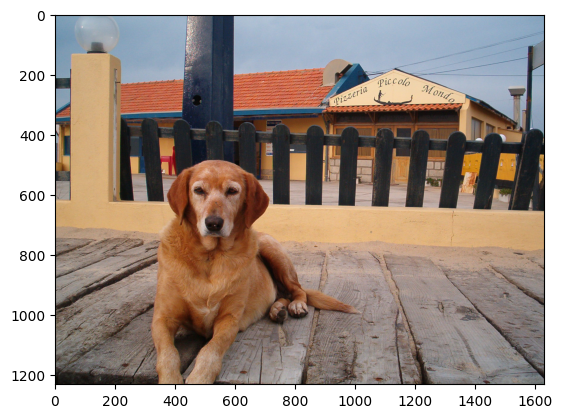

In [ ]:
# 이미지와 생성된 캡션 텍스트를 출력

%matplotlib inline

print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))